# Training Compiled Models

This notebook contains Oliver's in-development code for *training* a compiled model; might we observe the unlearning phenomenon? (This notebook is adapted from `examples/Visualize_Tracr_Models.ipynb`.)

In [1]:
#@title Imports
import jax
import numpy as np
import matplotlib.pyplot as plt
jax.config.update('jax_default_matmul_precision', 'float32') # The default of float16 can lead to discrepancies between outputs of the compiled model and the RASP program.
from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp
import jax.numpy as jnp             # Oliver added
import optax                        # Oliver added
import haiku as hk                  # Oliver added
import copy                         # Oliver added
import random                       # Oliver added
import json                         # Oliver added
seed = 3141592 + 3                  # Oliver added
random.seed(seed)                   # Oliver added
np.random.seed(seed)                # Oliver added

In [2]:
#@title Define RASP programs
def get_program(program_name, max_seq_len):
  """Returns RASP program and corresponding token vocabulary."""
  if program_name == "length":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_length()
  elif program_name == "frac_prevs":
    vocab = {"a", "b", "c", "x"}
    program = lib.make_frac_prevs((rasp.tokens == "x").named("is_x"))
  elif program_name == "dyck-2":
    vocab = {"(", ")", "{", "}"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}"])
  elif program_name == "dyck-3":
    vocab = {"(", ")", "{", "}", "[", "]"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}", "[]"])
  elif program_name == "sort":
    vocab = {1, 2, 3, 4, 5}
    program = lib.make_sort(
        rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
  elif program_name == "sort_unique":
    vocab = {1, 2, 3, 4, 5}
    program = lib.make_sort_unique(rasp.tokens, rasp.tokens)
  elif program_name == "hist":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_hist()
  elif program_name == "sort_freq":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_sort_freq(max_seq_len=max_seq_len)
  elif program_name == "pair_balance":
    vocab = {"(", ")"}
    program = lib.make_pair_balance(
        sop=rasp.tokens, open_token="(", close_token=")")
  else:
    raise NotImplementedError(f"Program {program_name} not implemented.")
  return program, vocab

In [3]:
#@title: Assemble model
program_name = "sort"  #@param ["length", "frac_prevs", "dyck-2", "dyck-3", "sort", "sort_unique", "hist", "sort_freq", "pair_balance"]
SORT_MAX = 5  #@param {label: "Test", type: "integer"} # largest number in the vocab

program, vocab = get_program(program_name=program_name,
                             max_seq_len=SORT_MAX)

print(f"   Program: {program_name}")
print(f"   Input vocabulary: {vocab}")
print(f"   Context size: {SORT_MAX}")

assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=SORT_MAX,
      causal=False,# aha
      compiler_bos="bos",
      compiler_pad="pad",
      mlp_exactness=100)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


   Program: sort
   Input vocabulary: {1, 2, 3, 4, 5}
   Context size: 5


In [4]:
# GENERATE A DATASET FOR TRAINING THE COMPILED MODEL
instance_lengths = 4
dataset_size = 10000
train_x = [["bos"]+random.choices(range(1,SORT_MAX+1),k=instance_lengths) for i in range(dataset_size)]
train_y = [["bos"]+sorted(x[1:]) for x in train_x]
dataset_size = 100
val_x = [["bos"]+random.choices(range(1,SORT_MAX+1),k=instance_lengths) for i in range(dataset_size)]
val_y = [["bos"]+sorted(x[1:]) for x in val_x]
dataset_size = 100
test_x = [["bos"]+random.choices(range(1,SORT_MAX+1),k=instance_lengths) for i in range(dataset_size)]
test_y = [["bos"]+sorted(x[1:]) for x in test_x]
# Confirm that the compiled model correctly solves the first few dataset instances
for i in range(3):
    print(train_x[i], train_y[i], assembled_model.apply(train_x[i]).decoded)

['bos', 1, 5, 5, 4] ['bos', 1, 4, 5, 5] ['bos', 1, 4, 5, 5]
['bos', 5, 3, 1, 3] ['bos', 1, 3, 3, 5] ['bos', 1, 3, 3, 5]
['bos', 5, 2, 1, 1] ['bos', 1, 1, 2, 5] ['bos', 1, 1, 2, 5]


In [5]:
# PERTURB THE PARAMETERS
PERTURBATION_FACTOR = 0 # if zero, the no perturbation; otherwise, order 10**(-3) seems to give a reasonable range
x = ["bos", 1,3,2,1]
print('BEFORE PERTURBATION')
out = assembled_model.apply(x)
print('x:',x)
print('output:',out.decoded)
print(out.attn_logits[0].shape)
print(out.transformer_output.shape)

# Construct/sample a small perturbation (for now, uniformly random reals in a small interval, e.g. [-.01, .01])
perturbation = copy.deepcopy(assembled_model.params)
for key in perturbation.keys():
    for key2 in perturbation[key].keys():
        perturbation[key][key2] = (np.random.rand(*perturbation[key][key2].shape) - .5) * PERTURBATION_FACTOR #np.zeros_like(perturbation[key][key2])#
# print(assembled_model.params['transformer/layer_2/attn/query']['w']) # Check before perturb

# Perturb model parameters
for key in assembled_model.params.keys():
    for key2 in assembled_model.params[key].keys():
        assembled_model.params[key][key2] += perturbation[key][key2]
# print(assembled_model.params['transformer/layer_2/attn/query']['w']) # Check after perturb

print('AFTER PERTURBATION:')
out = assembled_model.apply(x)
print('x:',x)
print('output:',out.decoded)
print(out.transformer_output.shape)
print(out.unembedded.shape)

BEFORE PERTURBATION
x: ['bos', 1, 3, 2, 1]
output: ['bos', 1, 1, 2, 3]
(1, 1, 5, 5)
(1, 5, 50)
AFTER PERTURBATION:
x: ['bos', 1, 3, 2, 1]
output: ['bos', 1, 1, 2, 3]
(1, 5, 50)
(1, 5)


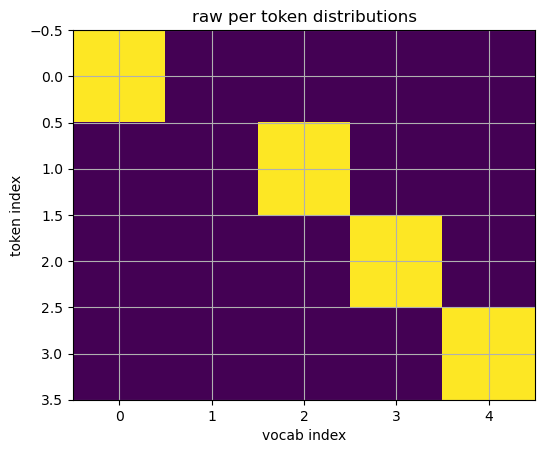

In [6]:
# PLOT THE PER-TOKEN OUTPUT DISTRIBUTIONS OVER THE VOCABULARY
x = ['bos',3,1,5,4]
raw_dists = copy.deepcopy(assembled_model.apply(x).raw_token_dists[0,1:,:]) #B,T,V
fig, ax = plt.subplots()
ax.imshow(raw_dists)
ax.set(xlabel='vocab index',ylabel='token index',title='raw per token distributions')
ax.grid()
plt.show()

In [7]:
# All the code below depends on using this function f as the model...  :/
f = assembled_model.functional_apply

# B=1 for now... (did I cause that or was it already like that?) TODO figure this out
def loss_fn(params, x, y):
    # Standard softmax cross entropy loss.
    logits = f(params,x).raw_token_dists[0,1:,:]                    # has shape [T-1, V] where T is sequence lenght and V is vocab size (T-1 because we don't train for the bos token)
    y_indices = assembled_model.input_encoder.encode(y)[1:]         # maps the ground truth y output tokens to their vocab indices (skips the bos token)
    y = jax.nn.one_hot(y_indices, logits.shape[-1])                 # get the one-hot encoding of the ground truth indices
    return -jnp.sum(y * jax.nn.log_softmax(logits)) / y.shape[0]    # compute and return the (average) cross entropy loss

# Can't jit this because of string input/output... TODO make numbers
def train_step(params, opt_state, x, y):
    grads = jax.grad(loss_fn)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

def eval(params, data_x, data_y):
    """ computes the average loss and accuracy of the function given by the passed params on the dataset data_x,data_y"""
    total_acc, total_loss = 0, 0
    for x,y in zip(data_x,data_y): #TODO batch not 1 by 1
        # TODO no need to forward pass twice (once for loss and once for accuracy)
        total_loss += float(loss_fn(params, x, y))
        y_pred = f(params,x).decoded
        total_acc += len([i for i, (y_pred, y) in enumerate(zip(y_pred, y)) if y_pred == y]) / len(y)
    return total_acc / len(data_x), total_loss / len(data_x)

# Experiment organization
expdir = '/space/oliver/tracr/tracr/experiments/' + '2024_sep_05_initial_experiments_2/'
val_acc_path = expdir + 'val_acc'
val_loss_path = expdir + 'val_loss'
# Save experimental details
lr = 1e-7
optimization_algorithm = 'sgd'
task = program_name
vocab = vocab
instance_lengths = instance_lengths
print(f"   Program: {program_name}")
print(f"   Input vocabulary: {vocab}")
print(f"   Context size: {SORT_MAX}")
# TODO TODO continue from here with the logging....
# TODO TODO continue from here with the logging....
# TODO TODO continue from here with the logging....
# TODO TODO continue from here with the logging....
# TODO TODO continue from here with the logging....

# Training loop
params = copy.deepcopy(assembled_model.params) # Initialize training from the perfect-accuracy parameters 
optimizer = optax.sgd(learning_rate=lr)
opt_state = optimizer.init(params)
val_acc, val_loss = [], []
VAL_FREQ = 100
for i, (x, y) in enumerate(zip(train_x,train_y)):
    # Validate every VAL_FREQ steps
    if i % VAL_FREQ == 0:
        acc, loss = eval(params, val_x, val_y)
        print(acc, loss)
        val_acc.append(acc)
        val_loss.append(loss)
        #save valacc andl sss
        with open(val_acc_path, "w") as fp:
            json.dump(val_acc, fp)
        with open(val_loss_path, "w") as fp:
            json.dump(val_loss, fp)
    # Perform a training step
    params, opt_state = train_step(params, opt_state, x, y)

   Program: sort
   Input vocabulary: {1, 2, 3, 4, 5}
   Context size: 5


1.0 0.904871940612793
1.0 0.9012876135110856


KeyboardInterrupt: 

In [ ]:
# PRINT VALIDATION LOSS AND ACCURACY CURVES


In [ ]:
# GARBAGE OLD CODE
# // ASSORTED DEBUGGING CODE
# print('So we have a compiled model for sorting:',assembled_model.model_config)
# print('x',x)
# print('out.decoded',out.decoded)
# # print('out.transformer_output.shape',out.transformer_output.shape)
# # print('out.unembedded[0]',out.unembedded[0])
# # print('out.attn_logits[-1].shape',out.attn_logits[-1].shape)
# # print('len(out.residuals)',len(out.residuals))
# # print('len(out.layer_outputs)',len(out.layer_outputs))
# # print('out.layer_outputs[-1].shape',out.layer_outputs[-1].shape)
# print('Among the many things in `out` we now have the following raw_token_dists...')
# print('out.raw_token_dists.shape',out.raw_token_dists.shape)
# print('out.raw_token_dists',out.raw_token_dists)
# print('Sanity check: can we decode from them manually?')
# raw_dists = out.raw_token_dists[0,:,:]
# # print(raw_dists.shape)
# argmaxed_dists = np.argmax(raw_dists,axis=1)
# print(argmaxed_dists)
# print([assembled_model.input_encoder.bos_token] + assembled_model.output_encoder.decode(argmaxed_dists.tolist())[1:])
# assembled_model.params['transformer/layer_0/attn/query']['b'][0]
# out = f.apply(initial_params,None,['bos',3,1,2])
# out.raw_token_dists.shape
# x,y = ['bos',3,1],['bos',1,3]
# params = train_step(params, opt_state, x, y)
# x, y = dataset_x[0], dataset_y[0]
# x,y = ['bos',3,1],['bos',1,3]
# print(x,y)
# loss_fn(initial_params,x,y)
# # What if we look at out.transformer_output?
# outs = out.transformer_output[0,:,:]
# print('out.transformer_output.shape',out.transformer_output.shape)
# embeddings = assembled_model.params['token_embed']['embeddings'].transpose()
# print('assembled_model.params.keys()',assembled_model.params.keys())
# print('outs.shape',outs.shape)
# print('tok_embeddings.shape',embeddings.shape)
# # pos_embeddings = assembled_model.params['pos_embed']['embeddings'].transpose()
# # print('pos_embeddings.shape',pos_embeddings.shape)
# distsmaybe = outs @ embeddings
# # pos_something = outs @ pos_embeddings
# print('distsmaybe',distsmaybe)
# # print('pos_something',pos_something)
# print('input x:',x)
# print('pretend output (undecoded):',np.argmax(distsmaybe,axis=1))
# print('pretend output (decoded):',assembled_model.input_encoder.decode(np.argmax(distsmaybe,axis=1)))

# model_config, module_names = _get_model_config_and_module_names(craft_model)
# model_config.causal = causal
# residual_space = bases.join_vector_spaces(craft_model.residual_space, tokens_space, indices_space, output_space)
# res_to_out = vectorspace_fns.project(residual_space, output_space)
# print(type(assembled_model.get_compiled_model()))# no need for that
# let's just try argmaxing this thing
# maybe it's actually logit like
# def unembed(x):
#     out = x @ res_to_out.matrix
#     return jnp.argmax(out, axis=-1)
# out.unembedded
# def compute_loss_and_updates(trainable_variables, non_trainable_variables, x, y):
#     y_pred, non_trainable_variables = model.stateless_call(
#         trainable_variables, non_trainable_variables, x
#     )
#     loss = loss_fn(y, y_pred)
#     return loss, non_trainable_variables

# grad_fn = jax.value_and_grad(compute_loss_and_updates, has_aux=True)
# (loss, non_trainable_variables), grads = grad_fn(
#     trainable_variables, non_trainable_variables, x, y
# )

# def train_step(state, data):
#     trainable_variables, non_trainable_variables, optimizer_variables = state
#     x, y = data
#     (loss, non_trainable_variables), grads = grad_fn(
#         trainable_variables, non_trainable_variables, x, y
#     )
#     trainable_variables, optimizer_variables = optimizer.stateless_apply(
#         grads, trainable_variables, optimizer_variables
#     )
#     # Return updated state
#     return loss, (
#         trainable_variables,
#         non_trainable_variables,
#         optimizer_variables,
#     )
# Train the compiled model
# num_epochs = 10
# batch_size = 100
# for epoch in range(num_epochs):
#     for batch_num in range(math.floor(len(dataset_x) / batch_size)):
#         idx = batch_num * batch_size
#         x_batch, y_batch = dataset_x[idx:idx+batch_size], dataset_y[idx:idx+batch_size]
#         for x in x_batch:
#             y_pred = assembled_model.apply(x)
#             print(y_pred.decoded)
#             # print(len(y_pred.layer_outputs))
#             # print(y_pred.layer_outputs[1])
#             print(y_pred.transformer_output[1])
#             break
#         break
#     break
# return params['transformer/layer_0/attn/query']['b'][0] #testing!!!!
# a = f.apply(params,x)
# return a[0,0,0]# can we even get a gradient through the returned raw logit things????
# return a.params['transformer/layer_0/attn/query']['b'][0]# can we even get a gradient through the returned chex data structure???
# print(type(a))
# par = copy.deepcopy(assembled_model.params)
# dummy_x = train_x[0]
# params = f.init(None,dummy_x)
# print(params)

# figure, ax = plt.subplots(figsize=(10, 8))
# line1, = ax.plot(x, y)
# val_loss_curve.set_ydata(val_losses)
# fig, ax = plt.subplots()
# val_loss_curve, = ax.plot([1,23,3,2,2,3,2,3,3,2,32,3,2,32,3,2])
# ax.set(xlabel='training steps',ylabel='loss',title='validation loss throughout training')
# ax.grid()
# plt.ion()
# plt.show() 

# val_loss_curve.set_xdata(range(len(val_losses)))#[i for i in range(len(val_losses))], [i for i in range(len(val_losses))])#val_losses)    # Update plot
# val_loss_curve.set_ydata(val_losses)
# fig.canvas.draw()
# fig.canvas.flush_events()
# print('here')
# print(val_losses)
#print(params)

#benjie:
# logits = f.apply(params, 0) #f.apply(params,{'pos_embed': {'embeddings': jnp.zeros_like(params['pos_embed']['embeddings'])}})
# return logits["mystuff"]
# f = hk.without_apply_rng(hk.transform(assembled_model.apply))
# fn = assembled_model.apply

# def testing(params):
#     assembled_model = compiling.compile_rasp_to_model(
#       program=program,
#       vocab=vocab,
#       max_seq_len=max_seq_len,
#       causal=False,# aha
#       compiler_bos="bos",
#       compiler_pad="pad",
#       mlp_exactness=100)
#     f = hk.without_apply_rng(hk.transform(assembled_model.apply))
#     return f.apply(params, 0)

# def oliver_testing(x):
#     assembled_model = compiling.compile_rasp_to_model(
#       program=program,
#       vocab=vocab,
#       max_seq_len=SORT_MAX,
#       causal=False,# aha
#       compiler_bos="bos",
#       compiler_pad="pad",
#       mlp_exactness=100)
#     return assembled_model.apply(x)
#loss = 0
# for (x,y) in zip(val_x,val_y):
#     loss += loss_fn(params, x, y)
# loss /= len(val_x)
# val_losses.append(loss)
# print(loss)

In [ ]:
# PLOTTING FUNCTIONS FROM THE ORIGINAL VERSION OF THIS NOTEBOOK

#@title Plotting functions
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"


def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )


def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)
  
#@title Plot residual stream
plot_residuals_and_input(
  model=assembled_model,
  inputs=["bos", 3, 4, 1],
  figsize=(10, 9)
)
#@title Plot residual stream
plot_residuals_and_input(
  model=assembled_model,
  inputs=["bos", 3, 4, 1],
  figsize=(10, 9)
)
#@title Plot layer outputs
plot_layer_outputs(
  model=assembled_model,
  inputs = ["bos", 3, 4, 1],
  figsize=(8, 9)
)